# Helper functions

In [ ]:
!pip install scikit-image

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [2]:
EPSILON = 1e-10

In [3]:
def load_image_rgb(path):
    """
    Load color image using OpenCV.
    """
    
    # read the image in BGR and covert to rgb
    img = cv2.imread(path)
    return img


def display_image_gray(img):
    """
    Display gray image using matplotlib.
    """
    plt.figure(figsize = (10,10))
    plt.imshow(img, cmap='gray')

    
def save_image(path, img):
    """
    Save image using OpenCV.
    """
    cv2.imwrite(path, img)
    
def save_image_scaled(path, img):
    """
    Save image using OpenCV.
    """
    img = ((img - img.min()) * (1/(img.max() - img.min()) * 255)).astype('uint8')
    cv2.imwrite(path, img)
    
    
    
def normalize_image(img):
    return img / np.amax(img)


def plot_pixel_histogram(img, title):
    histogram, bin_edges = np.histogram(img, 
                                    bins=256, 
                                    range=(img.min(), 
                                           img.max()))

    fig, ax = plt.subplots()
    plt.plot(bin_edges[0:-1], histogram)
    plt.title(title)
    plt.xlabel("pixel value")
    plt.ylabel("pixels")
    plt.xlim(img.min(), img.max())
    
    
def display_image_threshold(img, threshold):
    binary_mask = img > threshold
    fig, ax = plt.subplots()
    plt.axis('off')
    plt.title('')
    plt.imshow(binary_mask, cmap="gray")

# Load image

In [252]:
folder = 'lady'

In [253]:
image = load_image_rgb('images/' + folder + '.png')

In [254]:
#scale_factor=4
#img_height, img_width, _ = image.shape
#image = cv2.resize(image, (img_width//scale_factor, img_height//scale_factor), interpolation=cv2.INTER_AREA)

In [255]:
image_r, image_g, image_b = image[:,:,0], image[:,:,1], image[:,:,2]

In [256]:
image.min(), image.max()

(3, 255)

In [257]:
image.shape

(512, 512, 3)

In [258]:
#save_image('images/' + folder + '/src.png', image)

# Compute luminance

In [259]:
def compute_luminance_values(img):
    """
    Computing the luminance values on the basis of the RGB pixel input
    where: 
    
    L(x,y) = 0.212R(x, y) + 0.715G(x, y) + 0.072B(x, y) 
    
    [I.T.U. 1990]
    """
    
    # the luminosity coefficients according to the paper 
    # https://graphics.unizar.es/papers/LopezMoreno_NPAR2010.pdf
    luminosity_coeff_r = 0.213
    luminosity_coeff_g = 0.715
    luminosity_coeff_b = 0.072

    image_luminance_r = luminosity_coeff_r * img[:,:,0]
    image_luminance_g = luminosity_coeff_g * img[:,:,1]
    image_luminance_b = luminosity_coeff_b * img[:,:,2]
    
    image_luminance = image_luminance_r + image_luminance_g + image_luminance_b
            
    return image_luminance



In [260]:
image_luminance = compute_luminance_values(image)

In [261]:
image_luminance.min(), image_luminance.max()

(16.266999999999996, 240.974)

In [262]:
image_luminance.shape

(512, 512)

In [263]:
image_luminance

array([[140.852, 140.852, 142.34 , ..., 148.366, 132.292, 104.355],
       [140.852, 140.852, 142.34 , ..., 148.366, 132.292, 104.355],
       [140.852, 140.852, 142.34 , ..., 148.366, 132.292, 104.355],
       ...,
       [ 31.698,  31.698,  38.283, ...,  82.543,  77.192,  73.901],
       [ 33.775,  33.775,  42.998, ...,  79.765,  81.05 ,  83.483],
       [ 33.775,  33.775,  42.998, ...,  79.765,  81.05 ,  83.483]])

In [264]:
#save_image('images/' + folder + '/lumininace.png', image_luminance)

In [265]:
image_luminance = normalize_image(image_luminance)

In [93]:
#image_luminance.min(), image_luminance.max()

In [94]:
#image_luminance

In [95]:
#save_image('images/' + folder + '/lumininace_normalized.png', image_luminance)

In [96]:
#  Since contrast is a multiplicative effect, we work in the logarithmic domain
# https://people.csail.mit.edu/soonmin/CV/bw_photo_ring_toss_standard.pdf
#log_luminance = np.log10(image_luminance + EPSILON)

In [97]:
#log_luminance.min(), log_luminance.max()

In [98]:
#log_luminance

In [99]:
#log_luminance.shape

In [100]:
#save_image('images/' + folder + '/log_luminance.png', log_luminance)

# Bilateral Filter

In [266]:
import numpy as np
from math import sqrt

def gaussian(x, sigma, mu=0.0):
    # calculate the gaussian value
    exponent = (x - mu) / sigma
    return np.exp(-0.5 * exponent ** 2)

def calculate_dist(x0, y0, x1, y1):
    # calculate the distance between two points
    return sqrt((x1 - x0) ** 2 + (y1 - y0) ** 2)

def bilateral_pixel(src_img, result_img, x, y, filter_diameter, sigma, guide_sigma):
    # get height and width of image
    height = len(src_img[0])
    width =  len(src_img)
    
    # get filter radius
    radius = filter_diameter / 2

    # the output pixel value of the pixel at x,y
    output_pixel = 0
    # the sum of the weights
    total_weight = 0

    # loop over all pixels in filter diameter
    for neighbour_index_x in range(filter_diameter):
         for neighbour_index_y in range(filter_diameter):
            
            # get the neighbour pixel x and y
            neighbour_x = int(x - (radius - neighbour_index_x))
            neighbour_y = int(y - (radius - neighbour_index_y))

            # check if neighbour pixel is inside the image x 
            if neighbour_x < 0 or neighbour_x >= width:
                continue
       
            # check if neighbour pixel is inside the image y
            if neighbour_y < 0 or neighbour_y >= height:
                continue
            
            # calculate the distance between the pixel and the neighbour pixel
            px_distance = src_img[neighbour_x][neighbour_y] - src_img[x][y]
            
            # calculate distance between the pixel and the neighbour pixel
            dist = calculate_dist(neighbour_x, neighbour_y, x, y)

            gaus_i = gaussian(px_distance, sigma)
            gs = gaussian(dist, guide_sigma)
            # calculate the weight of the pixel
            w_i = gaus_i * gs

            output_pixel += src_img[neighbour_x][neighbour_y] * w_i
            total_weight += w_i

    # compute weighted mean of all neighbouring pixels     
    if total_weight == 0:
        output_pixel = src_img[x][y]
    else:
        output_pixel = output_pixel / total_weight

    # return the result pixel
    return output_pixel



def bilateral_filter_me(src_img, filter_diameter, sigma, guide_sigma):

    # empty output image with src image width and height
    
    height = len(src_img[0])
    width =  len(src_img)
    
    # result img empty
    result_img = np.zeros(src_img.shape)

    # loop over all pixels, x and y
    for x in range(width):
        for y in range(height):
            # apply bilateral filter for each pixel
            result_img[x][y] = bilateral_pixel(src_img, result_img, x, y, filter_diameter, sigma, guide_sigma)
    
    # return result
    return result_img


## Test bilateral filter against OpenCV version

In [211]:
bilateral_filter_custom = bilateral_filter_me(image_luminance, 1, 12.0, 16.0)

In [212]:
#save_image_scaled('images/bilateral_filter_me.png', bilateral_filter_custom)

In [213]:
bilateral_filter_custom.shape

(192, 256)

In [214]:
# src, d, sigmaColor, sigmaSpace
#bilateral_filter_OpenCV = cv2.bilateralFilter(image_luminance.astype(np.float32), 1, 12.0, 16.0)
#save_image_scaled("images/bilateral_filter_OpenCV.png", bilateral_filter_OpenCV)

# Bilateral Decomposition

In [290]:
height, width = image_luminance.shape
width, height

(512, 512)

In [293]:
def bilateral_decomposition(img):
    # configurations
    # consistently produces good results
    # https://people.csail.mit.edu/soonmin/CV/bw_photo_ring_toss_standard.pdf
    d = 10
    sigma_r = 0.2
    sigma_s = min(width, height) / 16
    
    # decomposition
    # base layer B, large scale features
    #CHANGE
    img_base = bilateral_filter_me(img.astype(np.float32), d, sigma_r, sigma_s)
    # D = I − B, detail layer D, small scale features
    img_detail = img - img_base
    return img_base, img_detail

In [294]:
B, D = bilateral_decomposition(image_luminance)

In [295]:
B.min(), B.max(), D.min(), D.max()

(0.086829446, 0.9042971, -0.22506922822510037, 0.27223315404859416)

In [296]:
#save_image_scaled('images/' + folder + '/base.png', B)

In [297]:
#save_image_scaled('images/' + folder + '/detail.png', D)

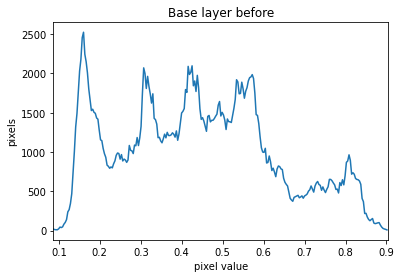

In [298]:
plot_pixel_histogram(B, 'Base layer before')

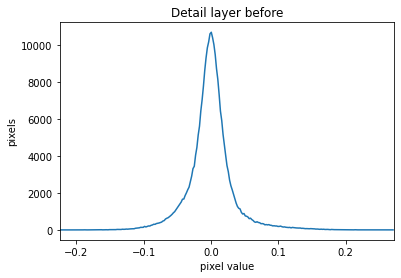

In [299]:
plot_pixel_histogram(D, 'Detail layer before')

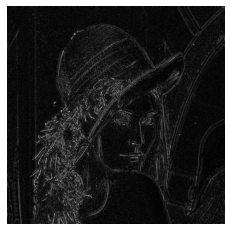

In [302]:
plt.axis('off')
plt.imshow(np.abs(D), cmap = 'gray')

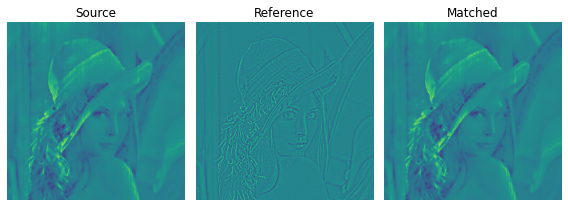

In [303]:
from skimage import data
from skimage import exposure
from skimage.exposure import match_histograms

reference = D
image = B

B = match_histograms(image, reference, channel_axis=-1)



fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3),
                                    sharex=True, sharey=True)
for aa in (ax1, ax2, ax3):
    aa.set_axis_off()

ax1.imshow(image)
ax1.set_title('Source')
ax2.imshow(reference)
ax2.set_title('Reference')
ax3.imshow(B)
ax3.set_title('Matched')

plt.tight_layout()
plt.show()

In [304]:
B.min(), B.max(), D.min(), D.max()

(-0.22506922, 0.27223316, -0.22506922822510037, 0.27223315404859416)

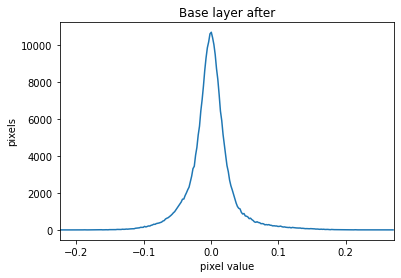

In [305]:
plot_pixel_histogram(B, 'Base layer after')

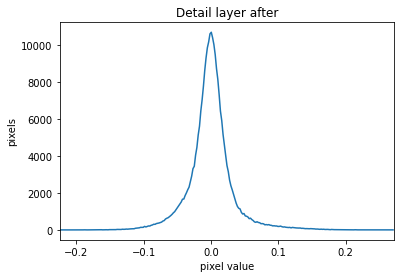

In [306]:
plot_pixel_histogram(D, 'Detail layer after')

# Reshaping function 
the methods based on the dark-is-deep assumption tend to produce
depth maps biased towards the direction of the light,**we smooth this
effect by filtering B(x, y) with a reshaping function [Khan et al.**
2006] which enforces its convexity, producing an inflation analogous to those achievable by techniques like Lumo [Johnston 2002].

Reshaping Function Smoothens Base Layer and Retains convexity

#  final approximate depth

https://graphics.unizar.es/papers/LopezMoreno_NPAR2010.pdf

Z(x, y) = FbB(x, y) + FdD(x, y)

Fb and Fd are user-defined weighting factors to control the presence of large and small features in the final image respectively, both
independent and ∈ [0, 1].

In [307]:
B.shape, D.shape

((512, 512), (512, 512))

In [308]:
def get_final_approx_depth(B, D, fB, fD):
    heigth = D.shape[1]
    width = D.shape[0]

    final_approx_depth = np.zeros(D.shape)

    for x in range(width):
        for y in range(height):
            final_approx_depth[x][y] = fB * B[x][y] + fD * D[x][y]
    
    return final_approx_depth

In [309]:
fB = 1
fD = 1
final_approx_depth = get_final_approx_depth(B, D, fB, fD)

In [310]:
final_approx_depth.shape

(512, 512)

In [311]:
final_approx_depth.min(), final_approx_depth.max()

(-0.34708627681041004, 0.4862456273948297)

In [312]:
final_approx_depth

array([[ 3.58841210e-02,  3.74214403e-02,  3.93556253e-02, ...,
         4.68222076e-02, -2.21380063e-02, -1.26037415e-01],
       [ 3.62182535e-02,  3.76573182e-02,  3.94079787e-02, ...,
         4.98392076e-02, -1.58757551e-02, -1.15420913e-01],
       [ 3.62635604e-02,  3.78486305e-02,  4.07637906e-02, ...,
         5.74164811e-02, -8.05374013e-03, -9.25408187e-02],
       ...,
       [-4.55015792e-02, -4.42891071e-02, -1.45185867e-02, ...,
         2.80754295e-02, -8.32427038e-05, -1.60624421e-02],
       [-3.67739116e-02, -3.49710537e-02,  5.38152680e-03, ...,
         1.18633408e-02,  1.01586583e-02,  1.77628579e-02],
       [-3.60842989e-02, -3.45426080e-02,  4.57643196e-03, ...,
         1.03580306e-02,  9.60427087e-03,  1.77562590e-02]])

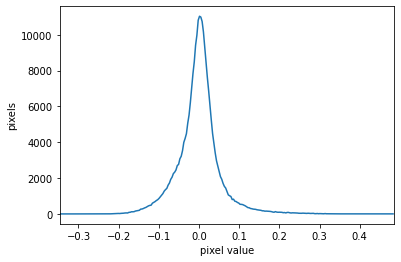

In [313]:
plot_pixel_histogram(final_approx_depth, '')

In [314]:
import skimage 
t = skimage.filters.threshold_otsu(final_approx_depth)
t

-0.00691758935163056

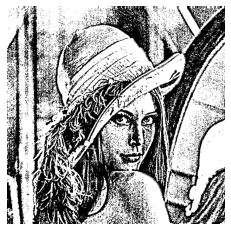

In [315]:
display_image_threshold(final_approx_depth, t)

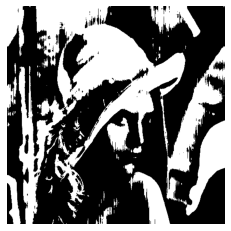

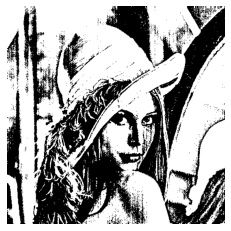

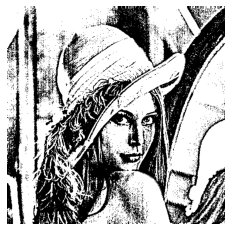

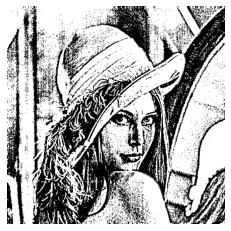

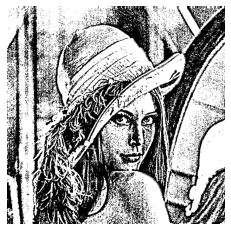

In [316]:
for i in range(0, 125, 25):
    fB = 1
    fD = (i / 100)
    final_approx_depth = get_final_approx_depth(B, D, fB, fD)
    t = skimage.filters.threshold_otsu(final_approx_depth)
    display_image_threshold(final_approx_depth, t)

# Halftoning

## Thresholding - mean image intensity

In [237]:
t = skimage.filters.threshold_otsu(final_approx_depth)

In [238]:
t

0.01562931780229654

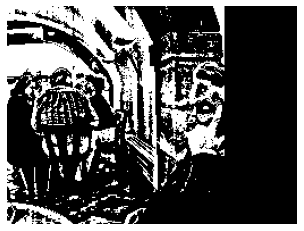

In [244]:
display_image_threshold(final_approx_depth, t)

## Adaptive threshodling 

In [240]:
    def apply_adaptive_thresholding(img: np.ndarray, threshold: float):
        """
        Apply adaptive thresholding on the image.

        "Adaptive Thresholding using the Integral Image". Derek Bradley &Gerhard Roth

        Args:
            img (np.ndarray): the image to apply adaptive thresholding on
            block_size (int): the size of the pixel neighborhood that is used to calculate the threshold value for the pixel
            C (int): a constant that is subtracted from the mean or weighted mean

        Returns:
            np.ndarray: the thresholded image
        """
        
        # resize image
        src_img = cv2.resize(img,(256, 196))

        # calculate the height and width of the image
        height = src_img.shape[0]
        width = src_img.shape[1]

         # calculate the integral image according to the paper
        integral_image = np.zeros_like(src_img, dtype=np.float32)

        for x in range(width):
            for y in range(height):
                integral_image[y][x] = img[0:y, 0:x].sum()

        # sample window size 
        sample_window_size = (width / 24)

        # initialize the thresholded image
        result = np.zeros_like(src_img)
        
        # loop over the image
        for x in range(width):
            for y in range(height):
                # calculate the x and y coordinates of the top left corner of the sample window
                x0 = round(max(0, x - sample_window_size ))
                x1 = round(min(width - 1, x + sample_window_size))

                y0 = round(max(0, y - sample_window_size ))
                y1 = round(min(height - 1, y + sample_window_size))

                
                # calculate the number of pixels in the sample window
                pixel_count = (x1 - x0) * (y1 - y0) 

                # calculate the sum of the pixels in the sample window
                sum_of_pixels = integral_image[y0, x0] - integral_image[y0, x1] - integral_image[y1, x0]  + integral_image[y1, x1]            
                
                thr = 1 - (threshold / 100)

                # calculate the mean of the pixels in the sample window
                if np.all(src_img[y,x] * pixel_count < sum_of_pixels * thr):
                    # set the pixel to white
                    result[y, x] = 0
                else:
                    # set the pixel to black
                    result[y, x] = 255

        return result

In [241]:
res = apply_adaptive_thresholding(final_approx_depth, 70)

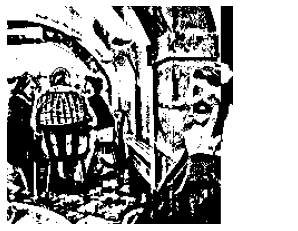

In [245]:
plt.axis('off')

plt.imshow(res, cmap="gray")